In [1]:
from importlib.metadata import version
print("torch version:", version("torch"))

torch version: 2.1.2


#### Stage 1 - **Building a LLM** 
1. Data preparation & sampling
2. ***Attention mechanism*** <----------------
3. LLM architecture

4. Pretraining

#### Stage 2 - **Foundation model**
5. Training loop 
6. Model evaluation
7. Load pretrained weights

8. Finetuning  -> dataset with class labels - classifier
              |-> instruction dataset - personal assistant



1. Simplified self-attention: A simplified self-attention technique to introduce the broader idea.
2. Self - attention: Self-attention with trainable weights that form the basis of the mechanism used in LLMs.
3. Causal attention: A type of self-attention used in LLMs that allows a model to consider only previous and current inputs in a sequence, ensuring temporal order during the text generation.
4. Multi-head attention: An extension of self-attention and casual attention that enables the model to simultaneously attend to info from different rep subspaces.

#### **Problem with modeling long sequence**
- Translating a text word by word isn't feasible due to the difference in grammatical structures between the souce and target languages

- The encoder processes a sequence of tokens from the source language, using a hidden state-- a kind of intermediate layer within the neural network -- to generate a condensed representation of the entire input sequence.
- Through an attention mechanism, the text-generating decoder segment of the network is capable of selectively accessing all the input tokens, implying that certain input tokens hold more significance than others in the generation of specific output token
- Self-attention in transformers is a technique designed to enhance input representations by enabling each position in a sequence to engage with and determine the relevance of every other position within the same sequence.


### Attending to different parts of the input with self-attention

#### Simple attention mechanism
- Suppose an input sequence x(1) to x(T), x(1) is a d-dimensional vector rep



In [20]:
# input seq that is embedded in 3-demensional vector

import torch 
inputs = torch.tensor([[0.43, 0.15, 0.89],    #Your
                       [0.55, 0.87, 0.66],          #journey
                       [0.57, 0.85, 0.64],    #Starts
                       [0.22, 0.58, 0.33],    #with
                       [0.77, 0.25, 0.10],    #one
                       [0.05, 0.80, 0.55]])   #step

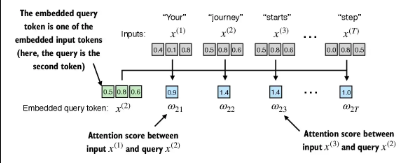

In [21]:
query = inputs[1]

attn_scores_2 = torch.empty(inputs.shape[0])

for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)

print(attn_scores_2) 

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


### **step 2 normalize the attenton score**

In [16]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())


Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


- however, in practice, using the softmax function for normalization, which is better at handling extreme values and has more desirable gradient properties during training, is common and recommended
- 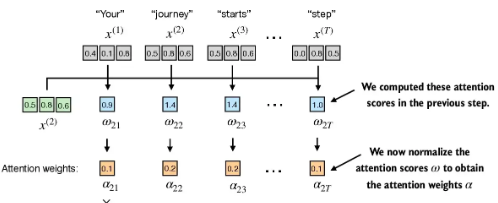

In [17]:
#naive implementation for softmax function
def softmax_func(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_softmax = softmax_func(attn_scores_2)

print("Attention weights:", attn_weights_2_softmax)
print("Sum:", attn_weights_2_softmax.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


- naive implementaion above can suffer from numerical instability issues for large or small input values due to overflow and underflow issues.
- In practice, its recommended to use the PyTorch implementation of softmax instead, which has been highly optimized for performance:

In [23]:
attn_weights_2 = torch.softmax(attn_scores_2, dim = 0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


### **step 3: compute the context vector z(2)**
- by multipling the embedded input tokens, x(i) with the attention weights and sum the resulting vectors
- 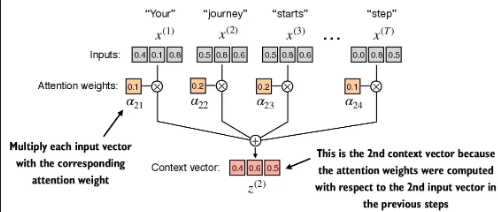

In [25]:
context_vec_2 = torch.zeros(query.shape)

for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])
